# Covid-19 
1. Evolução Itália, Espanha e Portugal
2. Comparação entre China e Itália 
3. Número casos, Mortos e Recuperados Portugal e alguns países europeus 
4. Adicionamos o que nos espera no final, considerando os casos de Itália e Espanha. Estamos com alguns dias de atraso em relação a estes países e dão indicadores para o que se vai passar no nosso país caso não sejam tomadas medidas mais restritivas e implementação de outras orientações.

As análises são atualizadas diariamente utilizando dados tratados pelo __Center for Systems Science and Engineering (CSSE) at Johns Hopkins University__ disponiveis em https://github.com/CSSEGISandData/COVID-19
Os dados diários são descarregados e combinados num ficheiro e atualizados online.

Procedimentos atualização dados:
```
git:
	cd ../covid-19;git reset --hard; git pull; 
	rm ../covid-19/csse_covid_19_data/csse_covid_19_daily_reports/bigfile.csv
	cd ../covid-19/csse_covid_19_data/csse_covid_19_daily_reports; awk '(NR == 1) || (FNR > 1)' *.csv > bigfile.csv
	cp -p "`ls -dtr ../covid_pt/datasets/*.csv | tail -1`" dados/covid_pt.csv
	cp -p "`ls -dtr ../covid-19/csse_covid_19_data/csse_covid_19_daily_reports/*.csv | tail -1`" dados/covid.csv
	#apaga primeira linha
	sed -i '1d' dados/covid.csv
	#insere cabs
	sed -i '1iProvince/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude' dados/covid.csv
	#Adicionar git
	git add .
	git commit -m "update"
	git push -u origin master
```

Análise desenvolvida por __Pedro Sobreiro__ e __António Moreira__ professores na Escola Superior de Desporto de Rio Maior e pode ser consultada em https://sobreiro.herokuapp.com/voila/render/analysis/Covid-19.ipynb

In [43]:
# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
import plotly.express as px

import warnings; 
warnings.simplefilter('ignore')

In [52]:
# importing datasets
full_table = pd.read_csv('https://raw.githubusercontent.com/pesobreiro/jupyternotebooks/master/dados/covid.csv',parse_dates=['Last Update'])


In [53]:
# Vamos limpar as linhas com nans
full_table.dropna(axis=0,how='all',inplace=True)

In [55]:
full_table.columns = ['Province/State', 'Country/Region', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Latitude', 'Longitude']

In [56]:
full_table.Date=full_table['Date'].dt.date

In [57]:
# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values with NA
full_table[['Province/State']] = full_table[['Province/State']].fillna('NA')

In [58]:
#full_table.drop_duplicates(subset=['Province/State','Country/Region', 'Date'], keep=False, inplace=True)

In [59]:
full_table.loc[((full_table.Date == pd.to_datetime('2020-03-11'))&(full_table['Country/Region']=='Spain')),'Confirmed'] = 2128
full_table.loc[((full_table.Date == pd.to_datetime('2020-03-11'))&(full_table['Country/Region']=='Germany')),'Confirmed'] = 1600
full_table.loc[((full_table.Date == pd.to_datetime('2020-03-18'))&(full_table['Country/Region']=='Portugal')),'Confirmed'] = 642

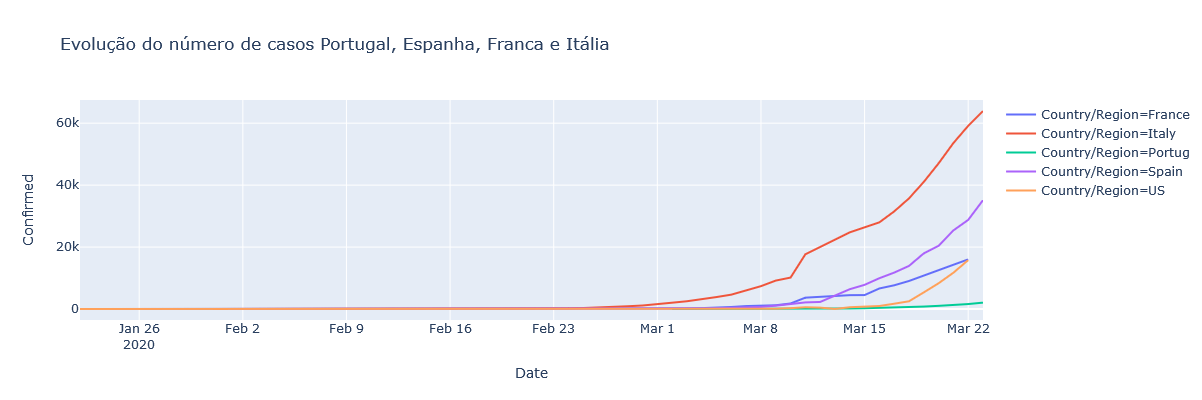

In [60]:
temp = full_table.loc[((full_table['Country/Region']=='Spain')| (full_table['Country/Region']=='Portugal')
                       |(full_table['Country/Region']=='France')| (full_table['Country/Region']=='Italy')
                       |(full_table['Country/Region']=='US'))]

temp = temp.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max().reset_index()
#temp = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)
temp.sort_values(by=['Country/Region','Date'],inplace=True)

temp = temp.reset_index()


fig = px.line(temp, x="Date", y="Confirmed", color='Country/Region',height=400,width=1000,
             title='Evolução do número de casos Portugal, Espanha, Franca e Itália')
fig.show()

Existe uma quebra na fonte para os dados no dia 11 para Espanha que está reportado como menos do que no dia anterior

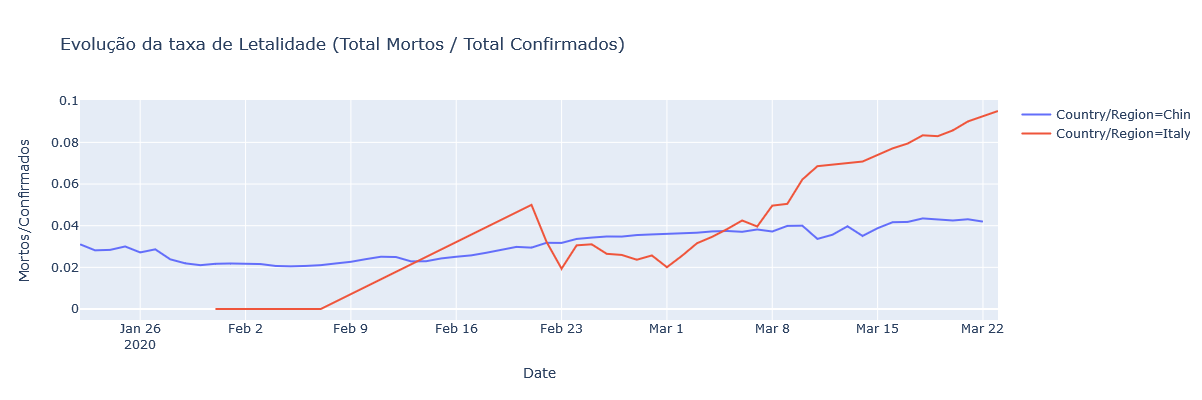

In [61]:
temp = full_table.loc[(full_table['Country/Region']=='Italy') | (full_table['Country/Region']=='China')]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum()

temp = temp.reset_index()
temp['Mortos/Confirmados'] = temp['Deaths']/temp['Confirmed']


fig = px.line(temp, x="Date", y="Mortos/Confirmados", color='Country/Region',height=400,width=1000,
             title='Evolução da taxa de Letalidade (Total Mortos / Total Confirmados)')
fig.show()

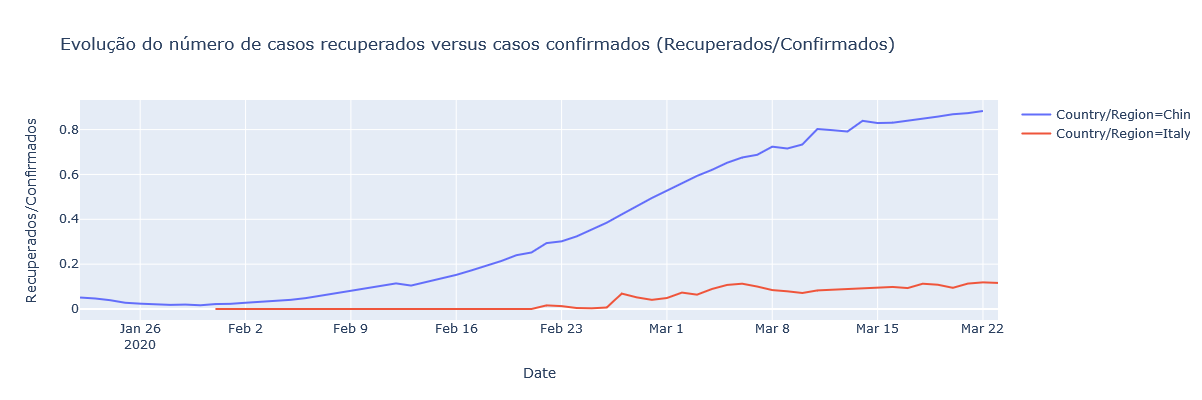

In [62]:
temp['Recuperados/Confirmados'] = temp['Recovered']/temp['Confirmed']

fig = px.line(temp, x="Date", y="Recuperados/Confirmados", color='Country/Region',  height=400,width=1000,
             title='Evolução do número de casos recuperados versus casos confirmados (Recuperados/Confirmados)')
fig.show()

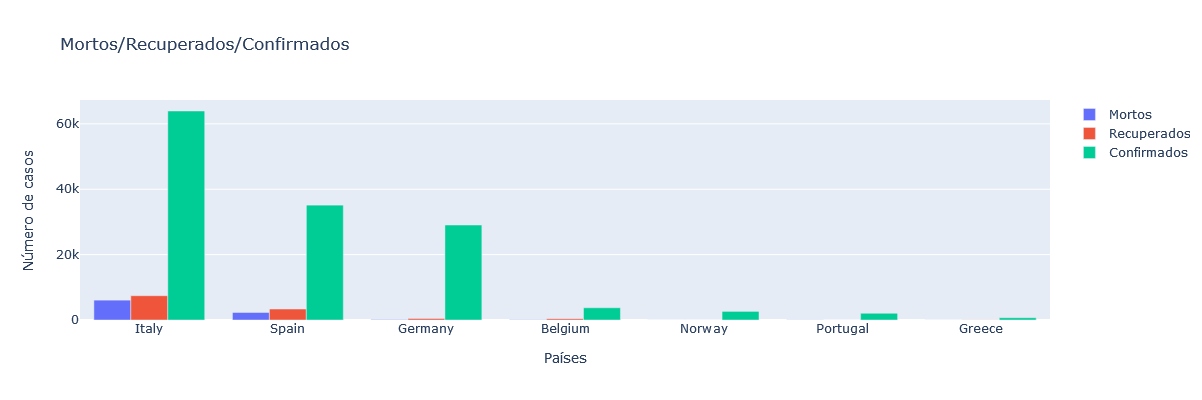

In [63]:
temp = full_table.loc[full_table.Date == full_table.Date.max()]
temp = temp.groupby(['Country/Region'])['Confirmed', 'Deaths', 'Recovered'].sum().sort_values('Confirmed',ascending=False)


europa = ['Italy', 'France', 'Germany', 'Spain', 'Belgium', 'Norway','Greece',  'Portugal']

temp=temp.reset_index()
temp=temp.loc[temp['Country/Region'].isin(europa)]


import plotly.graph_objects as go

layout = go.Layout(height=400,width=1000)

fig = go.Figure(data=[
    go.Bar(name='Mortos', x=temp['Country/Region'], y=temp['Deaths']),
    go.Bar(name='Recuperados', x=temp['Country/Region'], y=temp['Recovered']),
    go.Bar(name='Confirmados', x=temp['Country/Region'], y=temp['Confirmed']),
],layout=layout)

fig.update_layout(
    title="Mortos/Recuperados/Confirmados",
    xaxis_title="Países",
    yaxis_title="Número de casos",
)
fig.show()

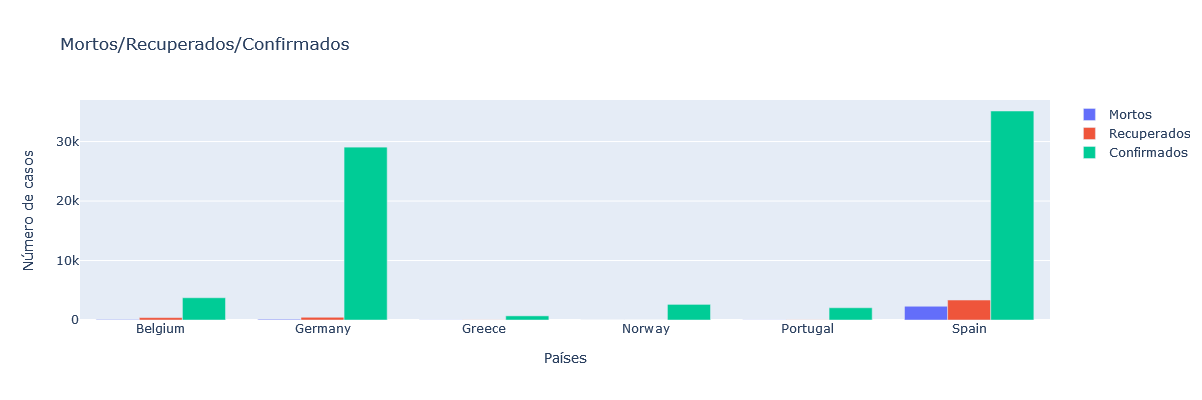

In [64]:
europa = [ 'France', 'Germany', 'Spain', 'Belgium', 'Norway','Greece',  'Portugal']
temp=full_table.loc[full_table.Date == full_table.Date.max()]
temp=temp.reset_index()
temp=temp.loc[temp['Country/Region'].isin(europa)]

layout = go.Layout(height=400,width=1000)

fig = go.Figure(data=[
    go.Bar(name='Mortos', x=temp['Country/Region'], y=temp['Deaths']),
    go.Bar(name='Recuperados', x=temp['Country/Region'], y=temp['Recovered']),
    go.Bar(name='Confirmados', x=temp['Country/Region'], y=temp['Confirmed']),
],layout=layout)

fig.update_layout(
    title="Mortos/Recuperados/Confirmados",
    xaxis_title="Países",
    yaxis_title="Número de casos",
)

fig.show()

## Casos portugal

```
git:
	cd ../covid_pt;git reset --hard; git pull
	cp -p "`ls -dtr ../covid_pt/datasets/*.csv | tail -1`" dados/covid_pt.csv
```

Dados obtidos em https://github.com/aperaltasantos/covid_pt

In [68]:
# importing datasets
dfPortugal = pd.read_csv('https://raw.githubusercontent.com/pesobreiro/jupyternotebooks/master/dados/covid_pt.csv',parse_dates=['date'])

In [69]:
dfPortugal=dfPortugal.fillna(0)

In [70]:
# dfPortugal.columns

In [71]:
dfPortugal.columns = ['data', 'casos_suspeitos', 'casos_suspeitos_novos', 'confirmados', 'confirmados_novos',
       'internados', 'internados_novos', 'cuidadosIntensivos', 'cuidadosIntensivos_novos', 'recuperados','recuperados_novos', 'mortos', 'mortos_novos']

In [72]:
temp = pd.melt(dfPortugal,id_vars='data',
               value_vars=['casos_suspeitos', 'confirmados', 'internados', 'cuidadosIntensivos', 'mortos'])

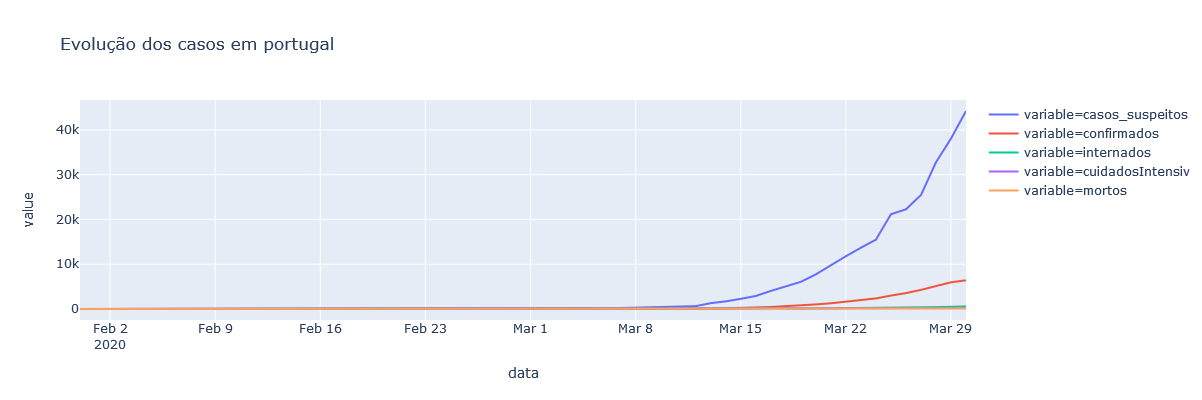

In [73]:
#temp['confirmed'] = temp['Recovered']/temp['Confirmed']

fig = px.line(temp, x="data", y="value", color = 'variable',height=400,width=1000,
             title='Evolução dos casos em portugal')
fig.show()

In [74]:
paises = ['Italy','Spain','France','Portugal','Germany','Switzerland','Denmark']

In [75]:
temp = full_table.loc[((full_table['Country/Region']=='Spain')| (full_table['Country/Region']=='Portugal')
                       |(full_table['Country/Region']=='France')| (full_table['Country/Region']=='Italy')
                       | (full_table['Country/Region']=='Germany')| (full_table['Country/Region']=='Switzerland')
                       | (full_table['Country/Region']=='Denmark'))]
temp = temp.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max().reset_index()

In [ ]:
#temp = temp.groupby(['Date'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

In [76]:
temp['dia'] = 0
i=0
for pais in paises:
    i=0
    for index, row in temp.loc[(temp['Country/Region']==pais)].iterrows():
        i = i + 1
        temp.at[index,'dia'] = i

## Espanha

Evolução dos casos em Espanha

In [77]:
temp.loc[temp['Country/Region']=='Spain'].style\
    .set_precision(0)\
    .background_gradient(cmap='Reds',subset=['Confirmed','Deaths','Recovered'])

,Date,Country/Region,Confirmed,Deaths,Recovered,dia
15,2020-02-01,Spain,1,0,0,1
22,2020-02-09,Spain,2,0,0,2
27,2020-02-15,Spain,2,0,2,3
37,2020-02-25,Spain,6,0,2,4
42,2020-02-26,Spain,13,0,2,5
47,2020-02-27,Spain,15,0,2,6
52,2020-02-28,Spain,32,0,2,7
57,2020-02-29,Spain,45,0,2,8
63,2020-03-01,Spain,84,0,2,9
69,2020-03-02,Spain,120,0,2,10


## Portugal

Evolução dos casos em Portugal

In [78]:
portugal=dfPortugal[['data','confirmados','mortos','recuperados']]
#Calcular o primeiro dia de casos
portugal = portugal.loc[portugal.confirmados !=0]

In [79]:
portugal['dia'] = 0
i=0
for pais in paises:
    i=0
    for index, row in portugal.iterrows():
        i = i + 1
        portugal.at[index,'dia'] = i

In [80]:
portugal.style\
    .set_precision(0)\
    .background_gradient(cmap='Reds',subset=['confirmados','mortos','recuperados'])

,data,confirmados,mortos,recuperados,dia
20,2020-03-02 00:00:00,2,0,0,1
21,2020-03-03 00:00:00,4,0,0,2
22,2020-03-04 00:00:00,6,0,0,3
23,2020-03-05 00:00:00,9,0,0,4
24,2020-03-06 00:00:00,13,0,0,5
25,2020-03-07 00:00:00,21,0,0,6
26,2020-03-08 00:00:00,30,0,0,7
27,2020-03-09 00:00:00,39,0,0,8
28,2020-03-10 00:00:00,41,0,0,9
29,2020-03-11 00:00:00,59,0,0,10


In [ ]:
#temp.loc[temp['Country/Region']=='Germany'].tail(100)

In [81]:
#,'Confirmed']=2128

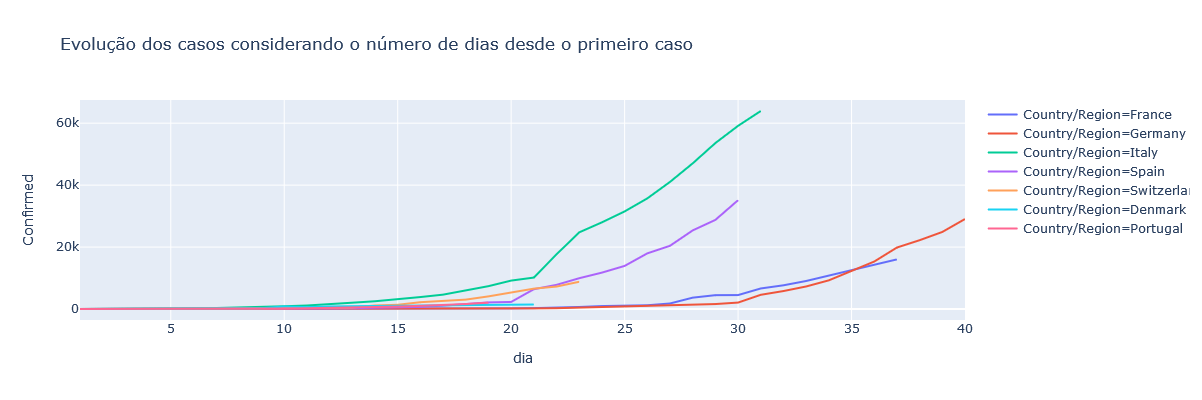

In [82]:
fig = px.line(temp, x="dia", y="Confirmed", color = 'Country/Region',height=400,width=1000,
             title='Evolução dos casos considerando o número de dias desde o primeiro caso')
fig.show()

França querer descolar e Espanha está com um comportamento muito parecido com Itália. Todos os países tinham menos de 200 casos no décimo dia excepto Suiça e Itália.
Os dados foram corrigidos na Espanha 11.03.2020 na Espanha com a informação de https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_42_COVID-19.pdf

In [ ]:
#temp=temp.loc[temp['dia']==1] 

In [83]:
'Número de casos no dia' + str(1)

'Número de casos no dia1'

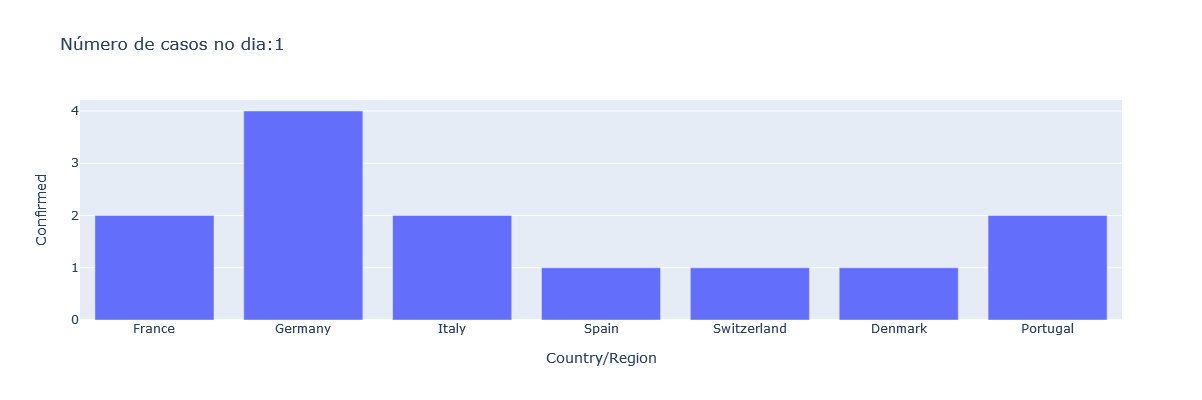

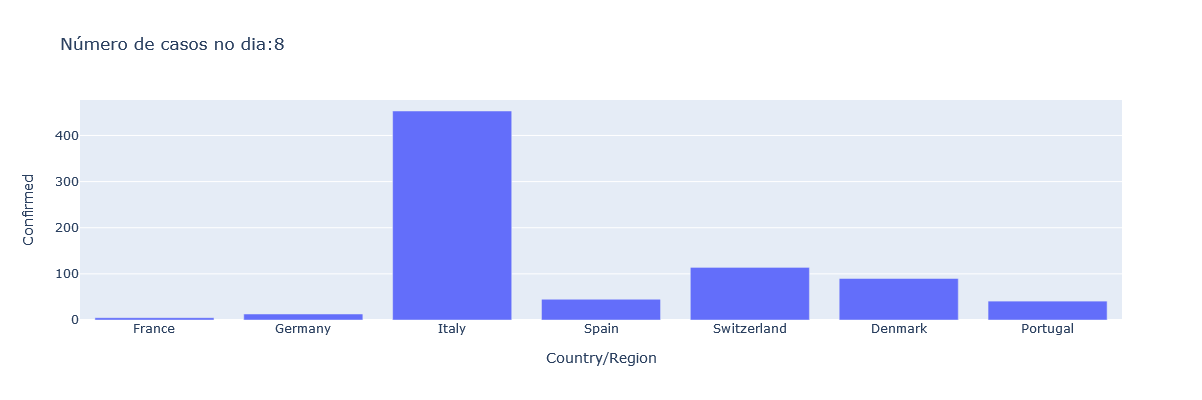

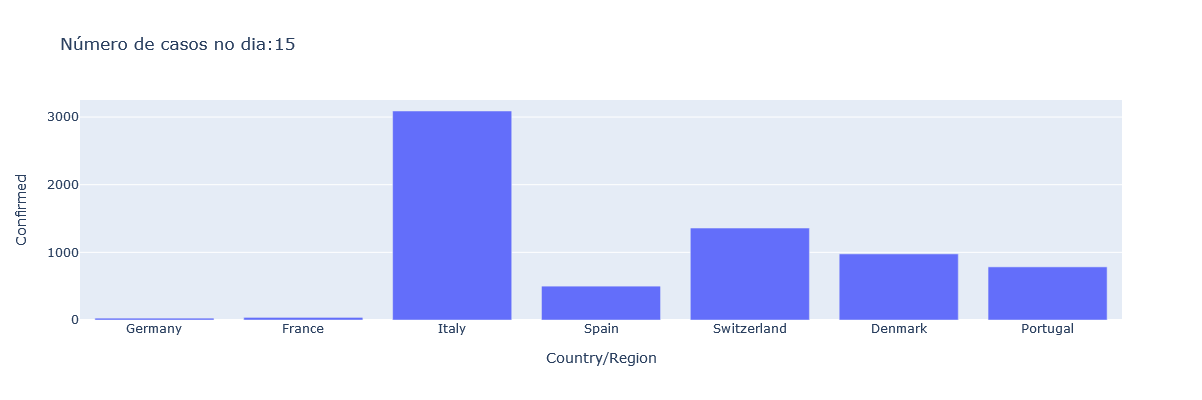

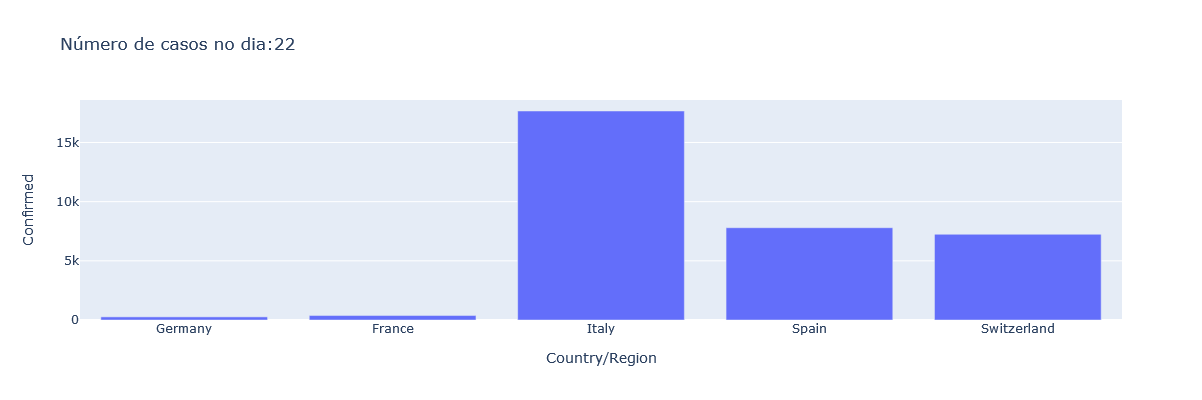

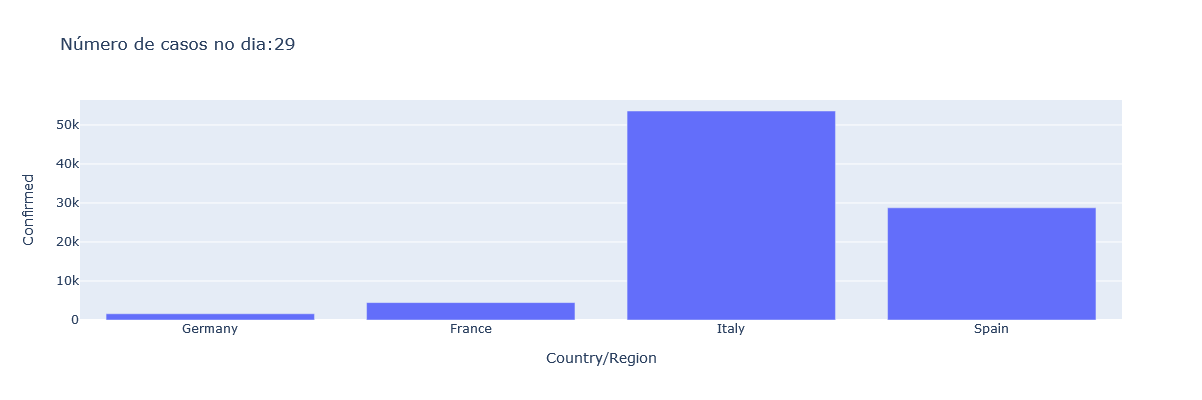

In [84]:
dias = [1,8,15,22,29]
for dia in dias:
    texto = 'Número de casos no dia:' + str(dia)
    fig = px.bar(temp.loc[temp['dia']==dia] , x="Country/Region", y="Confirmed", height=400,width=1000,
                 title=texto)
    fig.show()

# O que nos espera?
## Modelo SIR

Depois de vermos esta [notícia](https://observador.pt/especiais/a-matematica-que-explica-o-tsunami-europeu-e-portugues/) analisamos a possibilidade de reproduzir um modelo [SIR](https://en.m.wikipedia.org/wiki/Compartmental_models_in_epidemiology). O código foi criado a partir desta [análise](https://medium.com/analytics-vidhya/covid19-transmission-forecast-in-italy-a-python-tutorial-for-sri-model-8c103c0a95b9). Mais detalhes sobre a implementação do modelo em Python podem ser encontradas [aqui](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/).  Foram considerados como parâmetros um R0=3.5, com um S=10 Milhões, I=2 e R=0 numa fase inicial:

    - R0 = taxa de propagação do vírus
    - S = População passível de ser infetada
    - I = Infetados 
    - R = Recuperados da infeção
Assumimos que começamos com dois infetados e 0 recuperados    

In [85]:
import numpy as np
import random
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [86]:
# Total population, N.
N = 10e6
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 2, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.35, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 120, 121)
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

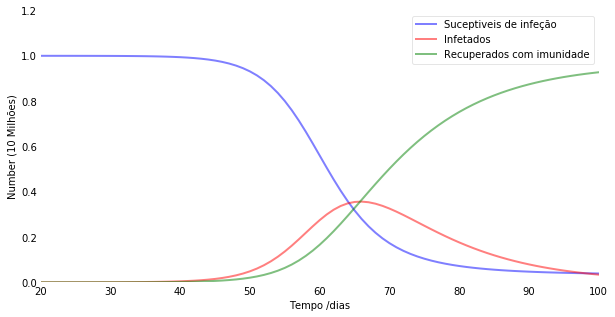

In [87]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=[10,5])
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Suceptiveis de infeção')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infetados')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recuperados com imunidade')
ax.set_xlabel('Tempo /dias')
ax.set_ylabel('Number (10 Milhões)')
ax.set_ylim(0,1.2)
ax.set_xlim(20,100)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Onde estamos na evolução dos casos do Covid-19?

O crescimento exponencial aplica-se até que o rácio de crescimento deixe de ser superior a 1. A partir desde momento estamos a aproximar de uma inflexão da curva. 

A teoria baseia-se no pressuposto de que as medidas estão a surtir efeito e que a evolução da propagação começa a ser controlada, o que pode ser associado ao maior isolamento social e maiores cuidados por parte da população. Estes dados são os casos reportados que podem não retratar os casos que não apresentam sintomas e que não estão a ser contabilizados.

Esta análise baseia-se nos conceitos explicados neste [vídeo](https://www.youtube.com/watch?v=Kas0tIxDvrg&t=118s)

TODO:Temos que criar uma Logistic-Regression para representarmos isto melhor e adicionar outros fatores para calcular a evolução 

### Vamos ver o que se passa em Itália

In [88]:
pais = temp.loc[temp['Country/Region']=='Italy']
pais = pais.reset_index()

pais.drop(['index'],axis=1,inplace=True)
pais['crescimento'] = 0

i=0
for index, row in pais.iterrows():
    if i==0:
        pais['crescimento'].iat[i] = 1
    else:
        pais['crescimento'].iat[i] = pais.Confirmed.iat[i]-pais.Confirmed.iat[i-1]
    i = i + 1


pais['racio'] = 0.0

i=0
for index, row in pais.iterrows():
    if i==0:
        pais['racio'].iat[i] = 1
    else:
        pais['racio'].iat[i] = pais.crescimento.iat[i]/pais.crescimento.iat[i-1]
    i = i + 1


pais.tail(10).style\
    .set_precision(2)\
    .background_gradient(cmap='Reds',subset=['Confirmed','Deaths','Recovered','crescimento','racio'])

,Date,Country/Region,Confirmed,Deaths,Recovered,dia,crescimento,racio
21,2020-03-11,Italy,17660.00,1266.00,1439.00,22,7511,7.69
22,2020-03-14,Italy,24747.00,1809.00,2335.00,23,7087,0.94
23,2020-03-16,Italy,27980.00,2158.00,2749.00,24,3233,0.46
24,2020-03-17,Italy,31506.00,2503.00,2941.00,25,3526,1.09
25,2020-03-18,Italy,35713.00,2978.00,4025.00,26,4207,1.19
26,2020-03-19,Italy,41035.00,3405.00,4440.00,27,5322,1.27
27,2020-03-20,Italy,47021.00,4032.00,4440.00,28,5986,1.12
28,2020-03-21,Italy,53578.00,4825.00,6072.00,29,6557,1.10
29,2020-03-22,Italy,59138.00,5476.00,7024.00,30,5560,0.85
30,2020-03-23,Italy,63927.00,6077.00,7432.00,31,4789,0.86


### O caso de Espanha

In [89]:
pais = temp.loc[temp['Country/Region']=='Spain']
pais = pais.reset_index()

pais.drop(['index'],axis=1,inplace=True)
pais['crescimento'] = 0

i=0
for index, row in pais.iterrows():
    if i==0:
        pais['crescimento'].iat[i] = 1
    else:
        pais['crescimento'].iat[i] = pais.Confirmed.iat[i]-pais.Confirmed.iat[i-1]
    i = i + 1


pais['racio'] = 0.0

i=0
for index, row in pais.iterrows():
    if i==0:
        pais['racio'].iat[i] = 1
    else:
        pais['racio'].iat[i] = pais.crescimento.iat[i]/pais.crescimento.iat[i-1]
    i = i + 1


pais.tail(10).style\
    .set_precision(2)\
    .background_gradient(cmap='Reds',subset=['Confirmed','Deaths','Recovered','crescimento','racio'])

,Date,Country/Region,Confirmed,Deaths,Recovered,dia,crescimento,racio
20,2020-03-14,Spain,6391.00,195.00,517.00,21,4114,27.61
21,2020-03-15,Spain,7798.00,289.00,517.00,22,1407,0.34
22,2020-03-16,Spain,9942.00,342.00,530.00,23,2144,1.52
23,2020-03-17,Spain,11748.00,533.00,1028.00,24,1806,0.84
24,2020-03-18,Spain,13910.00,623.00,1081.00,25,2162,1.20
25,2020-03-19,Spain,17963.00,830.00,1107.00,26,4053,1.87
26,2020-03-20,Spain,20410.00,1043.00,1588.00,27,2447,0.60
27,2020-03-21,Spain,25374.00,1375.00,2125.00,28,4964,2.03
28,2020-03-22,Spain,28768.00,1772.00,2575.00,29,3394,0.68
29,2020-03-23,Spain,35136.00,2311.00,3355.00,30,6368,1.88


Podemos ver que se considerarmos estes príncipios o surto em Espanha ainda não está controlado, os rácios dos últimos dias ainda não são conclusivos, mas são superiores a 1 de uma forma geral e aparentemente ainda não podemos identificar nenhum ponto de inflexão. 

### Portugal

In [90]:
portugal['crescimento'] = 0

i=0
for index, row in portugal.iterrows():
    if i==0:
        portugal['crescimento'].iat[i] = 1
    else:
        portugal['crescimento'].iat[i] = portugal.confirmados.iat[i]-portugal.confirmados.iat[i-1]
    i = i + 1


portugal['racio'] = 0.0

i=0
for index, row in portugal.iterrows():
    if i==0:
        portugal['racio'].iat[i] = 1
    else:
        portugal['racio'].iat[i] = portugal.crescimento.iat[i]/portugal.crescimento.iat[i-1]
    i = i + 1


portugal.tail(10).style\
    .set_precision(2)\
    .background_gradient(cmap='Reds',subset=['confirmados', 'mortos', 'recuperados','crescimento','racio'])

,data,confirmados,mortos,recuperados,dia,crescimento,racio
39,2020-03-21 00:00:00,1280,12,5,20,260,1.11
40,2020-03-22 00:00:00,1600,14,5,21,320,1.23
41,2020-03-23 00:00:00,2060,23,14,22,460,1.44
42,2020-03-24 00:00:00,2362,29,22,23,302,0.66
43,2020-03-25 00:00:00,2995,43,22,24,633,2.10
44,2020-03-26 00:00:00,3544,60,43,25,549,0.87
45,2020-03-27 00:00:00,4268,76,43,26,724,1.32
46,2020-03-28 00:00:00,5170,100,43,27,902,1.25
47,2020-03-29 00:00:00,5962,119,43,28,792,0.88
48,2020-03-30 00:00:00,6408,140,43,29,446,0.56


Um pouco confuso. Temos dias com mais casos, outros que temos o mesmo número de casos sem crescimento. Para evitar este problema passamos a utilizar para a análise de Portugal os dados da DGS atualizados [aqui](https://github.com/aperaltasantos/covid_pt).
Acontecimentos:
- Medidas contenção social 13-03-2020
- Encerramento das escolas 15-03-2020
- Declaração do Estado de Emergência 20-03-2020

Se aplicarmos esta fórmula:

$ Nd = (racio)^{dias} . casos $

- Se tivemos um rácio 1.13 nos 1020 casos, daqui a 30 dias temos 40000 casos, se tivermos um rácio de  1.2 teremos 240.000 casos, se tivermos de 1.3 será quase 2 milhões de casos.
- Se a Itália mantiver o rácio de 1.12 durante 4 dias significa que passa por exemplo de 47021 como tinha no dia 20 de Março para 73988 casos.


In [92]:
casos = portugal.confirmados.max()
print('Cenários a 10 dias considerando os casos de ',casos,' no último dia.')

racios=[1.10,1.20,1.30]
for racio in racios:
    print ('Rácio:',racio,'|Casos:',casos,'|Projeção:',round((racio**10)* casos,2))

Cenários a 10 dias considerando os casos de  6408  no último dia.
Rácio: 1.1 |Casos: 6408 |Projeção: 16620.7
Rácio: 1.2 |Casos: 6408 |Projeção: 39676.65
Rácio: 1.3 |Casos: 6408 |Projeção: 88339.72
